In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-urls-dataset/malicious_phish.csv


In [3]:
!pip install whois
!pip install pyquery

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.9 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import keras
import sklearn
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("sklearn version", sklearn.__version__)

TensorFlow version: 2.16.1
Keras version: 3.3.3
sklearn version 1.2.2


# DEFINITOIN OF URL FEATURE EXTRACTİON CLASS
### Feature Extraction Steps
* extract entropy
* extract count of digits
* extract url lenght
* extract count of parameters
* extract count of fragments
* extract count of subdomain
* extract domain extention
* extract http and https
* extract if is ip address
* return values of dict


In [5]:
import math

class FeatureExtractor:
    def __init__(self, url=""):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
    # Features
    def url_entropy(self):
        url_trimmed = self.url.strip()
        entropy_distribution = [float(url_trimmed.count(c)) / len(url_trimmed) for c in dict.fromkeys(list(url_trimmed))]
        return -sum([e * math.log(e, 2) for e in entropy_distribution if e > 0])

    def digits_num(self):
        return len([i for i in self.url if i.isdigit()])

    def length(self):
        return len(self.url)

    def params_num(self):
        return len(self.url.split('&')) - 1

    def fragments_num(self):
        return len(self.url.split('#')) - 1

    def subdomain_num(self):
        return len(self.domain.split('.')) - 1

    def dom_ext(self):
        return self.domain.split('.')[-1]

    def has_http(self):
        return 'http' in self.url

    def has_https(self):
        return 'https' in self.url

    def is_ip(self):
        parts = self.domain.split('.')
        if len(parts) == 4 and all(part.isdigit() and 0 <= int(part) <= 255 for part in parts):
            return True
        return False

    def run(self):
        return {
            "url": self.url,
            "entropy": self.url_entropy(),
            "digits": self.digits_num(),
            "url_length": self.length(),
            "param_nums": self.params_num(),
            "fragment_nums": self.fragments_num(),
            "subdomain_nums": self.subdomain_num(),
            "domain_extension": self.dom_ext(),
            "has_http": self.has_http(),
            "has_https": self.has_https(),
            "is_ip": self.is_ip(),
            "num_%20" : self.url.count("%20"),
            "num_@" : self.url.count("@")
        }




### Extracion of Fetures 

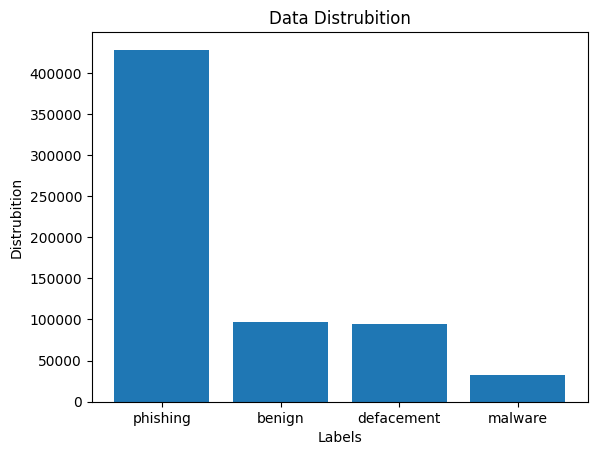

In [6]:
url = pd.read_csv(
    "/kaggle/input/malicious-urls-dataset/malicious_phish.csv"
)
counts = url["type"].value_counts()
plt.bar(url["type"].unique(),counts)
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

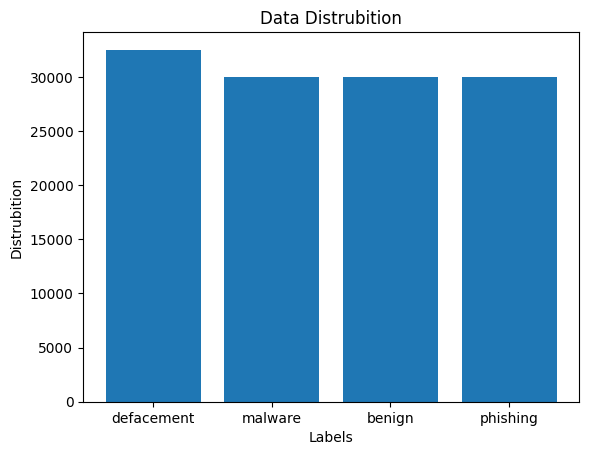

In [7]:

benign = url[url['type'] == 'benign']
malware = url[url['type'] == 'malware']
defacement = url[url['type'] == 'defacement']
phishing = url[url['type'] == 'phishing']

benign_downsampled = benign.sample(n=30000, random_state=55)
phishing_downsampled = phishing.sample(n=30000, random_state=55)
defacement_downsampled = defacement.sample(n=30000, random_state=55)

balanced_df = pd.concat([benign_downsampled, malware, defacement_downsampled, phishing_downsampled])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.bar(balanced_df["type"].unique(),balanced_df['type'].value_counts())
plt.title('Data Distrubition')
plt.xlabel('Labels')
plt.ylabel('Distrubition')
plt.show()

In [8]:
from tqdm import tqdm
features = []
for url in tqdm(balanced_df['url']):
    features.append(FeatureExtractor(url).run())
print(len(features))
features_df = pd.DataFrame(features)



100%|██████████| 122520/122520 [00:03<00:00, 35575.31it/s]


122520


### Show New Data

In [9]:
features_df["type"] = balanced_df["type"]
features_df.head(5)

,url,entropy,digits,url_length,param_nums,fragment_nums,subdomain_nums,domain_extension,has_http,has_https,is_ip,num_%20,num_@,type
0,http://dhc-sport.com/index2.php?option=com_vir...,4.655775,6,116,5,0,1,com,True,False,False,0,0,defacement
1,http://945wg.com/news/index.html?list_39_2.html,4.434819,6,47,0,0,1,com,True,False,False,0,0,defacement
2,http://9779.info/%E8%8E%B7%E5%A5%96%E6%A0%91%E...,3.911454,31,90,0,0,1,info,True,False,False,0,0,malware
3,http://aawsc.xyz/chrome.apk,4.032303,0,27,0,0,1,xyz,True,False,False,0,0,malware
4,http://www.poly-murau.at/index.php?option=com_...,4.630443,4,82,3,0,2,at,True,False,False,0,0,defacement


###  Define a tokenier for url tokenizing

In [10]:
features_df = features_df.dropna(subset=['type'])
features_df.head()
features_df["type"].value_counts()

type
malware       32520
defacement    30000
benign        30000
phishing      30000
Name: count, dtype: int64

In [11]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(features_df["url"])
sequences = tokenizer.texts_to_sequences(features_df['url'])
max_len = 100  
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print("done")

done


 ### Defining a label encoder for encoding classes

In [12]:

label_encoder = LabelEncoder()


features_df['type'] = label_encoder.fit_transform(features_df['type'])

y = to_categorical(features_df['type'], num_classes=4) 
y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

#### Converting extracted to numpy array 

In [13]:

extra_features = features_df[['entropy', 'digits', 'url_length', 'param_nums', 
                       'has_http', 'has_https', 'is_ip', 
                       'num_%20', 'num_@']].astype(np.int32).values
labels = features_df['type'].astype(np.int32).values


### Configuring our neural network with extracted features
* Input layer for url input
* embedding layer
* lstm out layer for url
* Input Layer for extracted features
* Dense layer for extracted features

Merging lstm output and extracted fetures output
Dropout definition
Output layer with size 4 

In [14]:
url_input = Input(shape=(100,), name="url_input")  
embedding = Embedding(input_dim=256, output_dim=64)(url_input)  
lstm_out = LSTM(64, return_sequences=False)(embedding)

features_input = Input(shape=(9,), name="extra_features") 
dense_features = Dense(32, activation="relu")(features_input)

merged = Concatenate()([lstm_out, dense_features])
dense1 = Dense(64, activation="relu")(merged)
dropout = Dropout(0.5)(dense1)
output = Dense(4, activation="softmax", name="output")(dropout)  


model = Model(inputs=[url_input, features_input], outputs=output)


model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ url_input           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │     16,384 │ url_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        320 │ extra_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,196 (219.52 KB)

 Trainable params: 56,196 (219.52 KB)

 Non-trainable params: 0 (0.00 B)

### Training Model
* Splitting data with extracted and seq values
* training model with batch size 32 and 4 epochs

In [15]:
X_train_seq, X_test_seq, X_train_extra, X_test_extra, y_train, y_test = train_test_split(
    padded_sequences, extra_features, y, test_size=0.2, random_state=42
)

In [16]:


history = model.fit(
    [X_train_seq, X_train_extra], y_train,
    epochs=30,  
    batch_size=32,
    validation_data=([X_test_seq, X_test_extra], y_test),
    verbose=1
)


Epoch 1/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5001 - loss: 1.4563 - val_accuracy: 0.6745 - val_loss: 0.7377
Epoch 2/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6526 - loss: 0.8233 - val_accuracy: 0.7065 - val_loss: 0.6884
Epoch 3/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6687 - loss: 0.7728 - val_accuracy: 0.6901 - val_loss: 0.6792
Epoch 4/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6760 - loss: 0.7472 - val_accuracy: 0.6911 - val_loss: 0.6799
Epoch 5/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.6781 - loss: 0.7368 - val_accuracy: 0.7004 - val_loss: 0.6616
Epoch 6/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6818 - loss: 0.7287 - val_accuracy: 0.7043 - val_loss: 0.6485
Epoch 7/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6886 - loss: 0.7161 - val_accuracy: 0.7869 - val_loss: 0.5228
Epoch 8/30
3063/3063 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7920 - loss: 0

## Report of model
printing loss and accuracy of our trained models


In [17]:
loss, accuracy = model.evaluate([X_test_seq,X_test_extra], y_test)
print(f"EXTRA FEATURES Test Loss: {loss}")
print(f"EXTRA FEATURES Test Accuracy: {accuracy}")

766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9136 - loss: 0.2421
EXTRA FEATURES Test Loss: 0.23212255537509918
EXTRA FEATURES Test Accuracy: 0.9160545468330383


 ### Classification Report of our model

In [23]:
y_pred = model.predict([X_test_seq,X_test_extra])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

      benign       0.88      0.88      0.88      5843
  defacement       0.96      0.99      0.97      6089
     malware       0.99      0.93      0.96      6567
    phishing       0.83      0.86      0.85      6005

    accuracy                           0.92     24504
   macro avg       0.92      0.92      0.91     24504
weighted avg       0.92      0.92      0.92     24504



### Confusion Matrix of Our Model

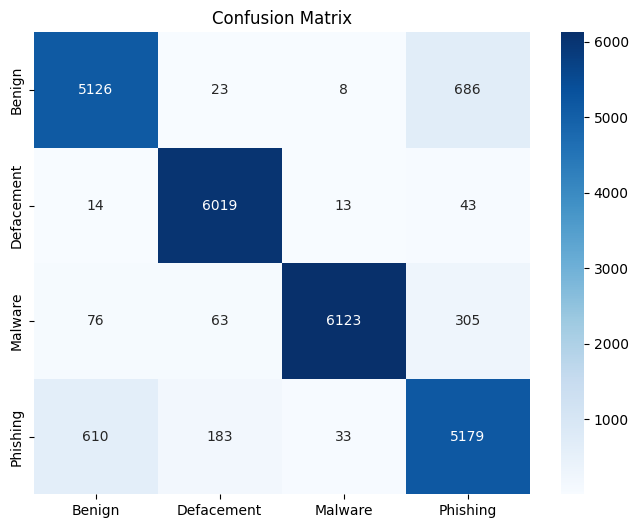

In [24]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Defacement", "Malware", "Phishing"], yticklabels=["Benign", "Defacement", "Malware", "Phishing"])
y
plt.title('Confusion Matrix')
plt.show()

In [26]:
model.save("MaliciousUrlDetector.h5")
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)
with open("label_encoder.pkl", "wb") as handle:
    pickle.dump(label_encoder, handle)


In [33]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import math

# Load the model and tokenizer
model = load_model("MaliciousUrlDetector.h5")
with open("tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)
with open("label_encoder.pkl", "rb") as handle:
    label_encoder = pickle.load(handle)

class FeatureExtractor:
    def __init__(self, url=""):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]

    def url_entropy(self):
        url_trimmed = self.url.strip()
        entropy_distribution = [float(url_trimmed.count(c)) / len(url_trimmed) for c in dict.fromkeys(list(url_trimmed))]
        return -sum([e * math.log(e, 2) for e in entropy_distribution if e > 0])

    def digits_num(self):
        return len([i for i in self.url if i.isdigit()])

    def length(self):
        return len(self.url)

    def params_num(self):
        return len(self.url.split('&')) - 1

    def fragments_num(self):
        return len(self.url.split('#')) - 1

    def subdomain_num(self):
        return len(self.domain.split('.')) - 1

    def dom_ext(self):
        return self.domain.split('.')[-1]

    def has_http(self):
        return 'http' in self.url

    def has_https(self):
        return 'https' in self.url

    def is_ip(self):
        parts = self.domain.split('.')
        if len(parts) == 4 and all(part.isdigit() and 0 <= int(part) <= 255 for part in parts):
            return True
        return False

    def run(self):
        return {
            "url": self.url,
            "entropy": self.url_entropy(),
            "digits": self.digits_num(),
            "url_length": self.length(),
            "param_nums": self.params_num(),
            "fragment_nums": self.fragments_num(),
            "subdomain_nums": self.subdomain_num(),
            "domain_extension": self.dom_ext(),
            "has_http": self.has_http(),
            "has_https": self.has_https(),
            "is_ip": self.is_ip(),
            "num_%20": self.url.count("%20"),
            "num_@": self.url.count("@")
        }

def check_url(url):
    if not url:
        return "Please enter a URL", None

    # Extract features
    extractor = FeatureExtractor(url)
    url_features = extractor.run()

    # Tokenize and pad the URL
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')

    # Prepare extra features
    extra_features = np.array([[url_features['entropy'], url_features['digits'],
                                url_features['url_length'], url_features['param_nums'],
                                url_features['has_http'], url_features['has_https'],
                                url_features['is_ip'], url_features['num_%20'],
                                url_features['num_@']]]).astype(np.int32)

    # Predict
    prediction = model.predict([padded_sequence, extra_features])
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = label_encoder.inverse_transform(predicted_class)

    # Format probabilities
    class_probabilities = dict(zip(label_encoder.classes_, prediction[0]))
    sorted_probabilities = sorted(class_probabilities.items(), key=lambda x: x[1], reverse=True)
    formatted_probabilities = {cls: round(prob * 100, 2) for cls, prob in sorted_probabilities}

    return f"Predicted class: {class_labels[0]}", formatted_probabilities

def main():
    while True:
        url = input("Enter URL (or type 'exit' to quit): ")
        if url.lower() == 'exit':
            break
        result, probabilities = check_url(url)
        print(result)
        print("Prediction probabilities:")
        for cls, prob in probabilities.items():
            print(f"  {cls}: {prob}%")

if __name__ == "__main__":
    main()


Enter URL (or type 'exit' to quit):  	http://117.211.208.123:37836/bin.sh


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted class: phishing
Prediction probabilities:
  phishing: 63.87%
  malware: 36.13%
  defacement: 0.0%
  benign: 0.0%


Enter URL (or type 'exit' to quit):  https://www.kaggle.com/code/burakcanbul/malicious-url-detection-with-lstm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class: benign
Prediction probabilities:
  benign: 45.94%
  phishing: 39.69%
  malware: 14.38%
  defacement: 0.0%


Enter URL (or type 'exit' to quit):  http://104.193.59.142:37024/i


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: malware
Prediction probabilities:
  malware: 100.0%
  phishing: 0.0%
  defacement: 0.0%
  benign: 0.0%


Enter URL (or type 'exit' to quit):  exit
